## Calculation of near-surface humidity from ERA5 

needed parameters: 

- 2m dew point temperature 
- surface pressure 

In [411]:
import numpy as np 
import xarray as xr

file = '../moisture_transport/moisture_transport/cache/srfc-monthly/reanalysis-era5-single-levels-monthly-means_201908_total_column_water_vapour-surface_pressure-2m_dewpoint_temperature10-60-50-130.nc'

data = xr.open_dataset(file)
sp = data.sp[0].values/100
temperature = data.d2m[0].values
tcwv = data.tcwv[0]

In [412]:
def get_surface_humidity(temperature, spressure):
    
    #### define constants #### 

    # gas constants for dry air and water vapour in J K-1 kg-1
    Rdry= 287
    Rvap= 461
    # constants for Tetens formula (for saturation over water)
    c1= 611.21
    c2= 17.502
    c3= 32.19
    # freezing point
    T0 = 273.16 
    
    spressure = spressure*100
    e_sat = c1* np.exp( c2 * ((temperature - T0)/ (temperature - c3)))
    
    q_sat = ((Rdry / Rvap) * e_sat ) / (spressure - (1- Rdry/Rvap) * e_sat )
    return q_sat

In [414]:
q_surface = get_surface_humidity(temperature, sp)

## Compare column-integration

In [345]:
def column_integration(data, sp,qlev, temperature):
    from scipy import interpolate
    import wrf 
    coords = np.where(sp < 10000)
    pressure = np.zeros((37,201,321))
    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]

        pressure[:,ilat,ilon]= qdata.level.values
        pressure[36, :, :] =  sp
        idx, pl = atm.find_nearest_idx(qdata.level.values, sp_value)

        # function to calculate surface humidity
        q_surface = get_surface_humidity(temperature, sp)

        # set q value below ground to 0 
        if sp_value < 1000:
            pressure[idx, ilat,ilon] = sp_value
            qlev[idx, ilat, ilon] =  q_surface[ilat,ilon]
            qlev[idx+1:37, ilat, ilon] =  0

        if sp_value > 1000:
            qlev[36, ilat, ilon] = q_surface[ilat,ilon]

    return atm.colint_pressure(qlev, pressure)



In [404]:
# q at pressure levels 
f= '/media/juli/Data/projects/moisture_transport/moisture_transport/cache/pressure-monthly/reanalysis-era5-pressure-levels-monthly-means_201908_q10-60-50-130.nc'
qdata= xr.open_dataset(f)
qlev= qdata.q[0].values

In [391]:
colint = column_integration(qdata,sp, qlev, temperature)

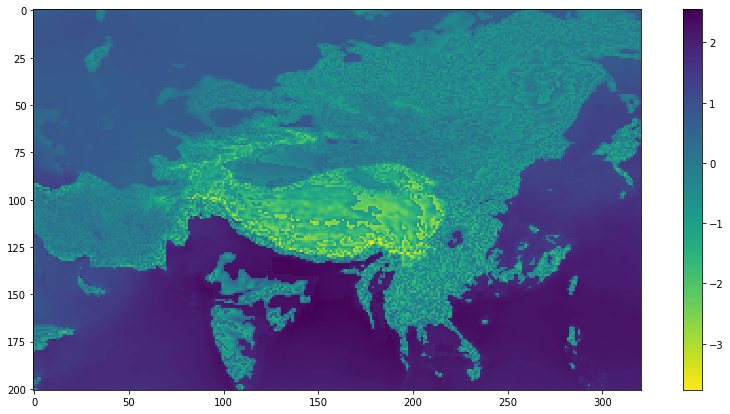

In [392]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.imshow(tcwv.values - colint, cmap = 'viridis_r')
plt.colorbar()
plt.show()

In [409]:
def column_integration_q(data, sp, q):
    from scipy import interpolate
    import wrf 
    coords = np.where(sp < 10000)
    pressure = np.zeros((37,201,321))
    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]

        pressure[:,ilat,ilon]= data.level.values
        pressure[36, :, :] =  sp
        idx, pl = atm.find_nearest_idx(data.level.values, sp_value)

        # function for extrapolation/ interpolation: 
        x_vals = data.level.values
        y_vals= q[:,ilat,ilon]
        f = interpolate.interp1d(x_vals, y_vals, fill_value = "extrapolate", kind = 'cubic')

        # set q value below ground to 0 
        if sp_value < 1000:
            pressure[idx, ilat,ilon] = sp_value
            q[idx, ilat, ilon] =  f(sp_value)
            q[idx+1:37, ilat, ilon] =  0

        if sp_value > 1000:
            q[36, ilat, ilon] = f(sp_value)

    colint = atm.colint_pressure(q, pressure)

    return colint

In [410]:
colint2= column_integration_q(qdata, sp, qlev)

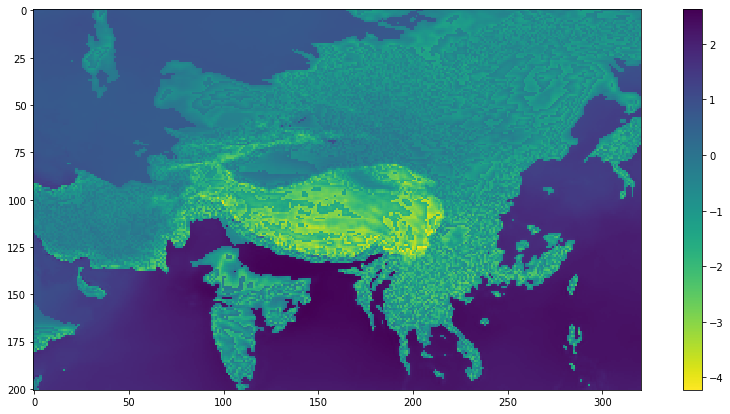

In [403]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.imshow(tcwv.values - colint2, cmap = 'viridis_r')
plt.colorbar()
plt.show()

**Conclusion:**
    
- near-surface humidity calculation does not give any improvement and is about the same as if values are simply interpolated and extrapolated to the surface pressure level. 